In [1]:
## checks timestamps for errors in sequence


In [38]:

import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import random
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d01_data.fetch.fetch_viewings import fetch_viewings
from src.d01_data.fetch.fetch_trials import fetch_trials
from src.d01_data.database.Errors import InvalidValue
from scipy.stats import pearsonr

In [19]:
all_viewings = fetch_viewings("all" )
all_viewing_ids = np.unique(all_viewings.viewing_id)
n_viewings = len(all_viewing_ids)
faulty_viewings = []
# print(ppts)
for i in range(n_viewings):
    viewing = all_viewing_ids[i]
    tps = fetch_timepoints("all", ret_epochs=['na', 'view', 'full'], viewing_id=viewing, suppress_print=True)
    if tps is None or len(tps) < 2:
        continue
    timestamp = tps.eye_timestamp_ms.to_numpy()
    frame = tps.eye_frame_number.to_numpy()
    r, p = pearsonr(timestamp, frame)
    if r < 0.999:   # should be almost perfectly correlated
        faulty_viewings.append(viewing)
        # ax = plt.figure().add_subplot()
        # ax.plot(timestamp, frame, 'r.')
        # title = f'viewing {viewing}, r ={r}'
        # print(title)
        # ax.set_title(title)
        # plt.show()


- fetching viewings from db...
viewings fetched from db
dataframe returned in 0.015956401824951172
dataframe returned in 0.016954898834228516
dataframe returned in 0.01595616340637207
dataframe returned in 0.01795196533203125
dataframe returned in 0.014960050582885742
dataframe returned in 0.01695394515991211
dataframe returned in 0.015957117080688477
dataframe returned in 0.01795172691345215
dataframe returned in 0.014960527420043945
dataframe returned in 0.020943403244018555
dataframe returned in 0.015958309173583984
dataframe returned in 0.018948793411254883
dataframe returned in 0.015957117080688477
dataframe returned in 0.01795220375061035
dataframe returned in 0.014988183975219727
dataframe returned in 0.016954421997070312
dataframe returned in 0.015956401824951172
dataframe returned in 0.01695561408996582
dataframe returned in 0.015020370483398438
dataframe returned in 0.01994609832763672
dataframe returned in 0.014959096908569336
dataframe returned in 0.019918203353881836
dataf

In [20]:
faulty_viewings

['alloeye_12r2_6_enc',
 'alloeye_19r3_5_ret',
 'alloeye_35r3_17_enc',
 'alloeye_36r1_5_ret',
 'alloeye_44r2_0_enc',
 'alloeye_4r3_11_ret',
 'alloeye_50r2_5_enc',
 'alloeye_6r3_0_enc']

dataframe returned in 0.013962030410766602
[441]
441
503
62


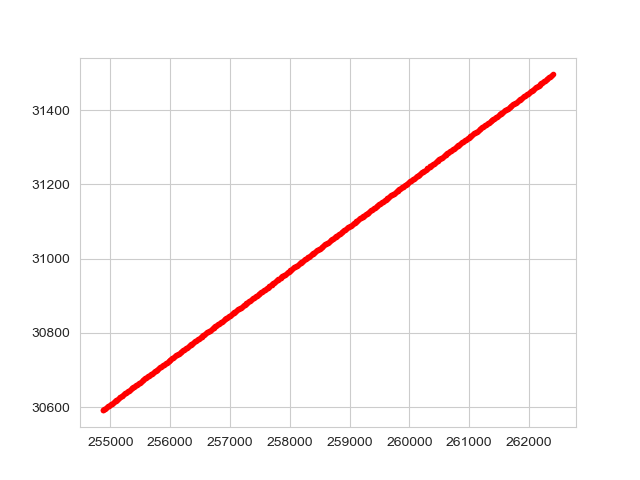

dataframe returned in 0.018948793411254883
[202]
202
730
528


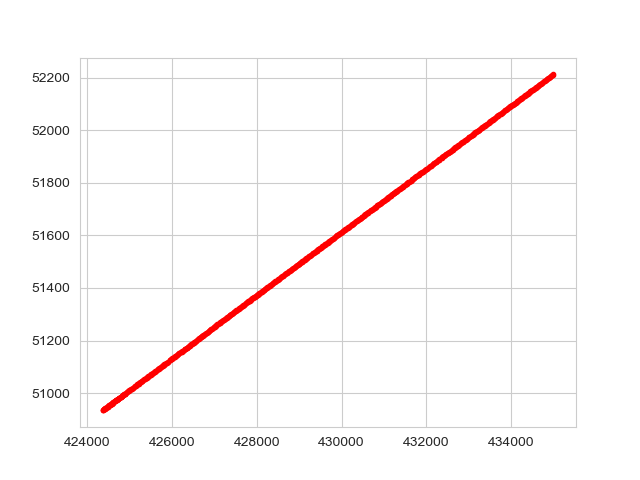

dataframe returned in 0.014961481094360352
[266]
266
482
216


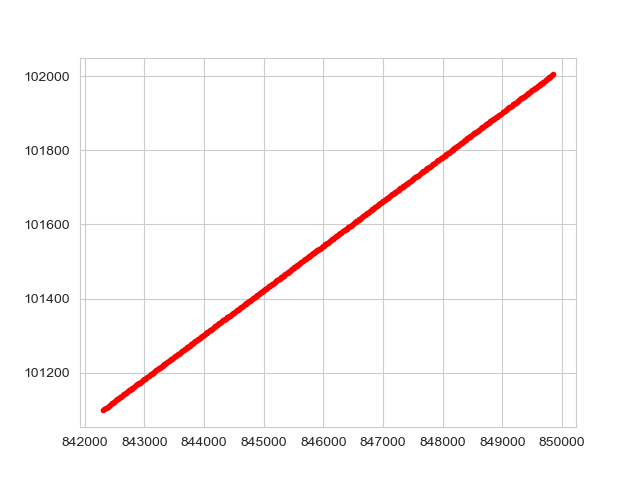

dataframe returned in 0.016954898834228516
[565]
565
644
79


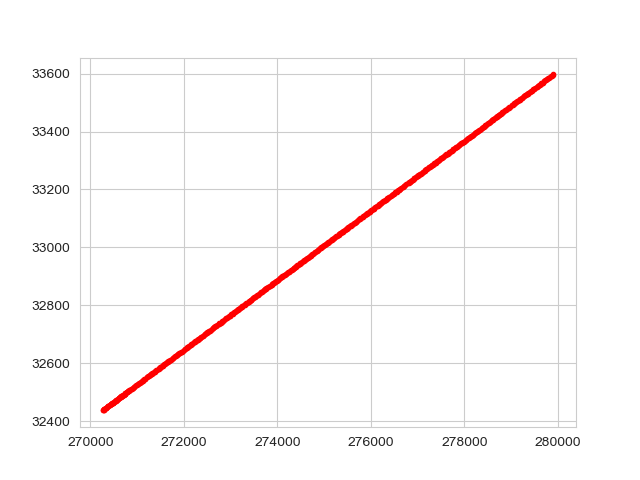

dataframe returned in 0.013962507247924805
[289]
289
490
201


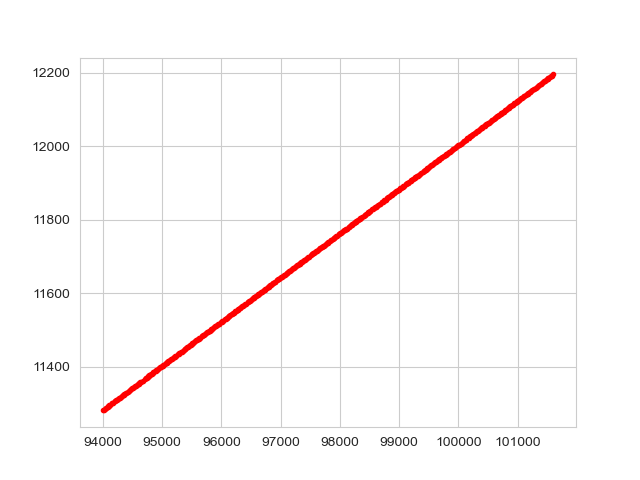

dataframe returned in 0.01795172691345215
[185]
185
600
415


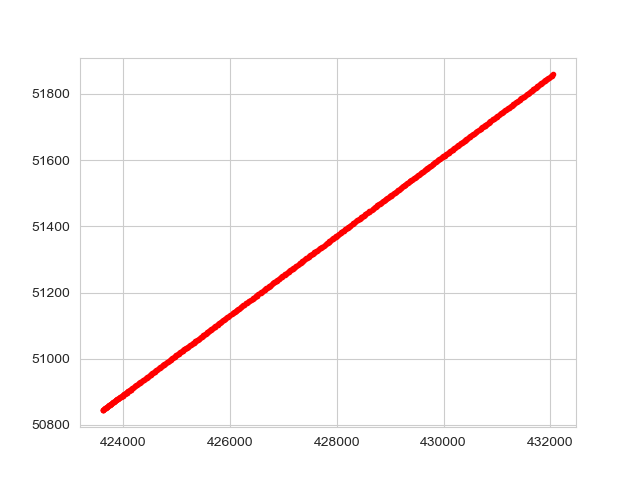

dataframe returned in 0.015956640243530273
[263]
263
616
353


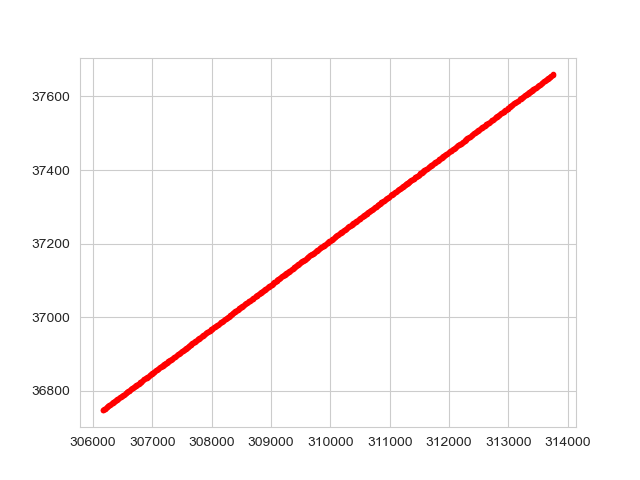

dataframe returned in 0.014959096908569336
[202]
202
481
279


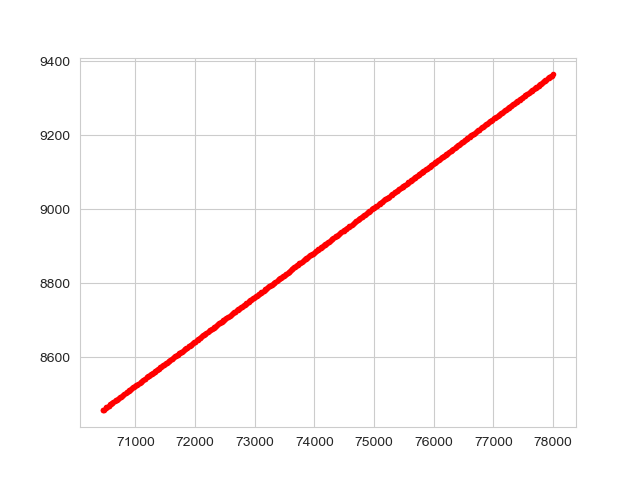

In [39]:
def timestamp_split_correction(viewing_tps, t_diff_threshold=20000):
    """function to correct error with timestamp recordings: occasionally and inexplicably drops timestamps to very low negative number in middle of viewing. The following checks for this and outputs a corrected dataframe. """

    # none checks
    if viewing_tps is None:
        return viewing_tps
    if len(viewing_tps) < 2:
        return viewing_tps

    # copy
    tps = viewing_tps.copy(deep=True)

    # check for one viewing, otherwise will combine timestamps for both viewings
    if len(np.unique(tps.viewing_id)) > 1:
        raise InvalidValue(len(np.unique(tps.viewing_id)), 1, message="too many viewings in timepoints")

    # calculate correlation between timestamp and frame, should be almost 1
    timestamp = tps.eye_timestamp_ms.to_numpy()
    frame = tps.eye_frame_number.to_numpy()
    r, p = pearsonr(timestamp, frame)

    # of correlation too low (will be negative if timestamp split)
    if r < 0.999:   # should be almost perfectly positively correlated

        # sort by frame (which never seems to have the problem)
        tps = tps.sort_values(by='eye_frame_number').reset_index(drop=True)
        frames = tps.eye_frame_number.to_numpy()
        timestamps = tps.eye_timestamp_ms.to_numpy()

        # find where split happens (accounts for more than 1 although haven't seen yet)
        split_idxs = []
        for i in range(len(frames)-1):
            this_timestamp = timestamps[i]
            next_timestamp = timestamps[i+1]
            if np.abs(next_timestamp - this_timestamp) > t_diff_threshold:
                split_idxs.append(i+1)

        # correction: split into chunks, assume mean timestep, carry on from previous chunk
        for i in range(len(split_idxs)):
            split_idx = split_idxs[i]
            chunk_1 = tps.iloc[:split_idx, :].eye_timestamp_ms.to_numpy()
            chunk_2 = tps.iloc[split_idx:, :].eye_timestamp_ms.to_numpy()
            chunk_1_diff_mean = np.mean(np.diff(chunk_1))
            chunk_2_diff_mean = np.mean(np.diff(chunk_2))
            diff_mean = np.mean([chunk_1_diff_mean, chunk_2_diff_mean]).astype(int)
            chunk_1_end = chunk_1[-1]
            chunk_2_start = chunk_2[0]
            chunk_2 -= chunk_2_start
            chunk_2 += chunk_1_end + diff_mean
            tps.loc[split_idx:, 'eye_timestamp_ms'] = chunk_2

    return tps

for viewing in faulty_viewings:
    tps = fetch_timepoints("all", ret_epochs=['na', 'view', 'full'], viewing_id=viewing, suppress_print=True)
    tps = timestamp_split_correction(tps)
    ax = plt.figure().add_subplot()
    ax.plot(tps.eye_timestamp_ms, tps.eye_frame_number, 'r.')
    plt.show()

dataframe returned in 0.014960527420043945
[441]
441
503
62
441
(62,)
62


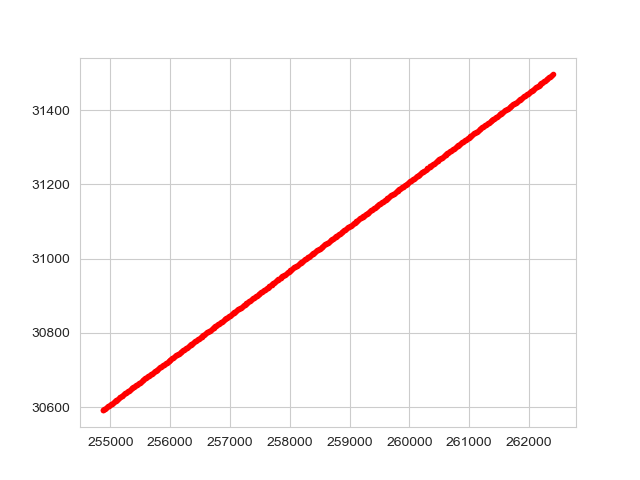

dataframe returned in 0.018978118896484375
[202]
202
730
528
202
(528,)
528


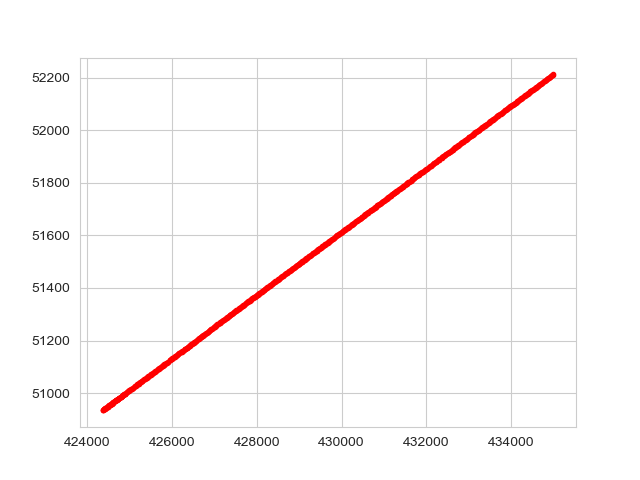

dataframe returned in 0.014960289001464844
[266]
266
482
216
266
(216,)
216


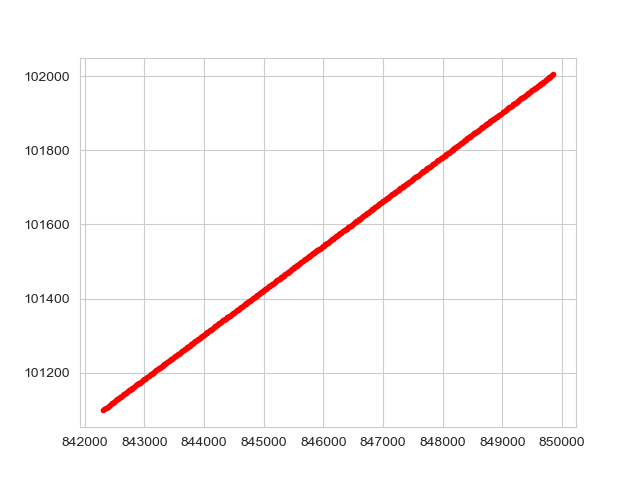

dataframe returned in 0.01795172691345215
[565]
565
644
79
565
(79,)
79


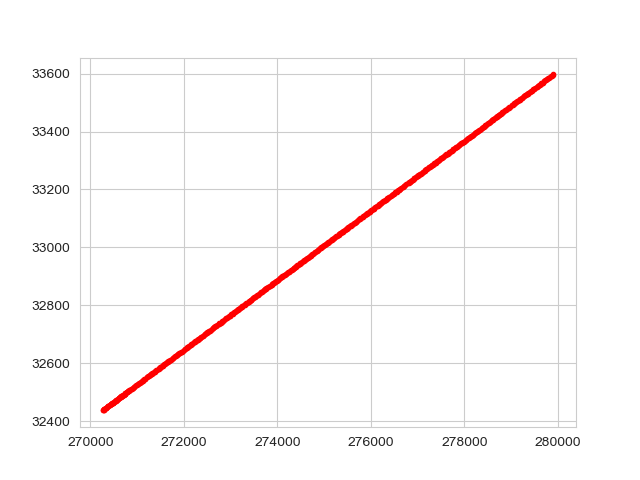

dataframe returned in 0.015241622924804688
[289]
289
490
201
289
(201,)
201


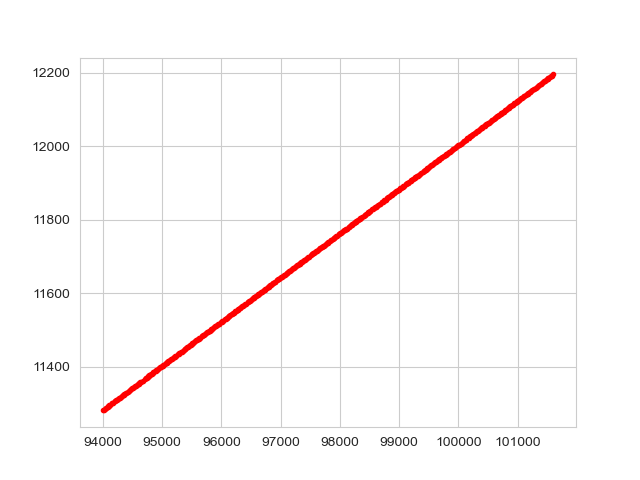

dataframe returned in 0.016984224319458008
[185]
185
600
415
185
(415,)
415


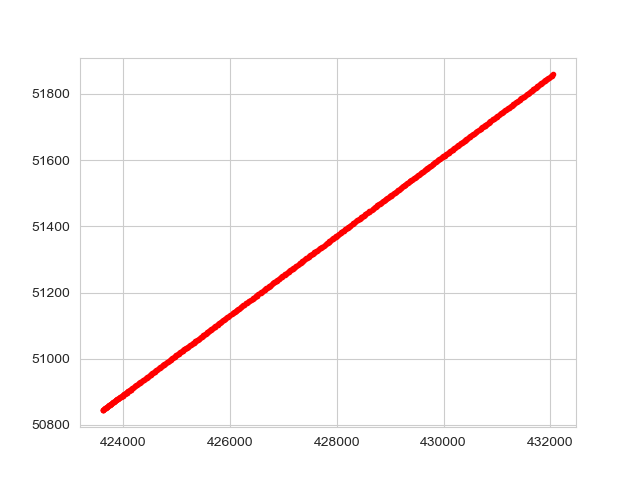

dataframe returned in 0.016954660415649414
[263]
263
616
353
263
(353,)
353


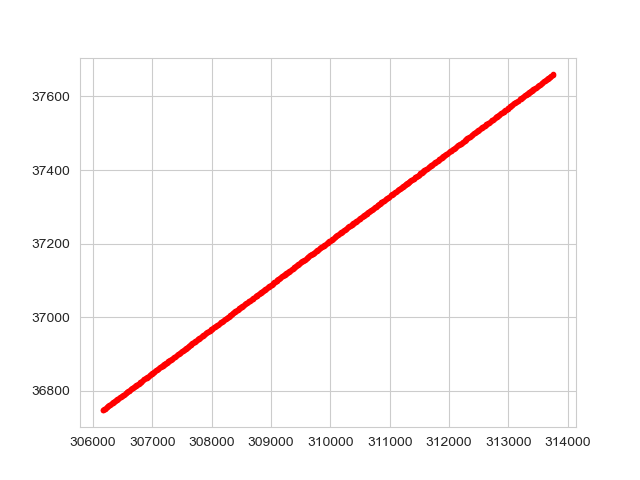

dataframe returned in 0.014960527420043945
[202]
202
481
279
202
(279,)
279


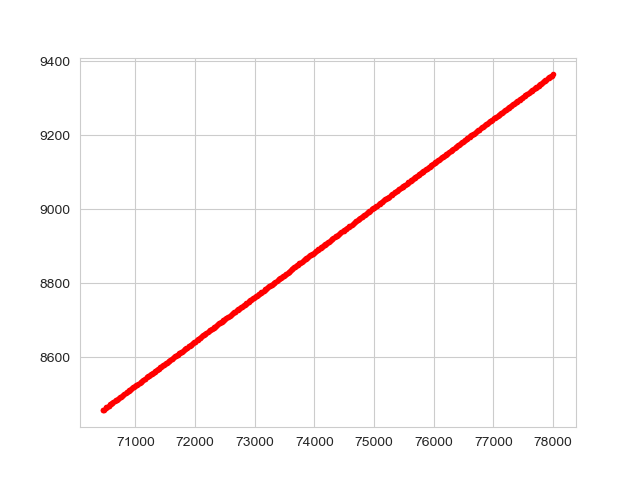

In [37]:

t_diff_threshold = 20000
for viewing in faulty_viewings:
    tps = fetch_timepoints("all", ret_epochs=['na', 'view', 'full'], viewing_id=viewing, suppress_print=True)
    tps = tps.copy(deep=True)

    tps = tps.sort_values(by='eye_frame_number').reset_index(drop=True)

    frames = tps.eye_frame_number.to_numpy()
    timestamps = tps.eye_timestamp_ms.to_numpy()
    split_idxs = []
    for i in range(len(frames)-1):
        this_timestamp = timestamps[i]
        next_timestamp = timestamps[i+1]
        if np.abs(next_timestamp - this_timestamp) > t_diff_threshold:
            split_idxs.append(i+1)
    print(split_idxs)
    for i in range(len(split_idxs)):
        split_idx = split_idxs[i]
        print(split_idx)
        print(len(tps))
        chunk_1 = tps.iloc[:split_idx, :].eye_timestamp_ms.to_numpy()
        chunk_2 = tps.iloc[split_idx:, :].eye_timestamp_ms.to_numpy()
        print(len(chunk_2))
        chunk_1_diff_mean = np.mean(np.diff(chunk_1))
        chunk_2_diff_mean = np.mean(np.diff(chunk_2))
        diff_mean = np.mean([chunk_1_diff_mean, chunk_2_diff_mean]).astype(int)
        chunk_1_end = chunk_1[-1]
        chunk_2_start = chunk_2[0]
        chunk_2 -= chunk_2_start
        chunk_2 += chunk_1_end + diff_mean
        tps.loc[split_idx:, 'eye_timestamp_ms'] = chunk_2

    ax = plt.figure().add_subplot()
    ax.plot(tps.eye_timestamp_ms, tps.eye_frame_number, 'r.')
    plt.show()



dataframe returned in 0.01495981216430664


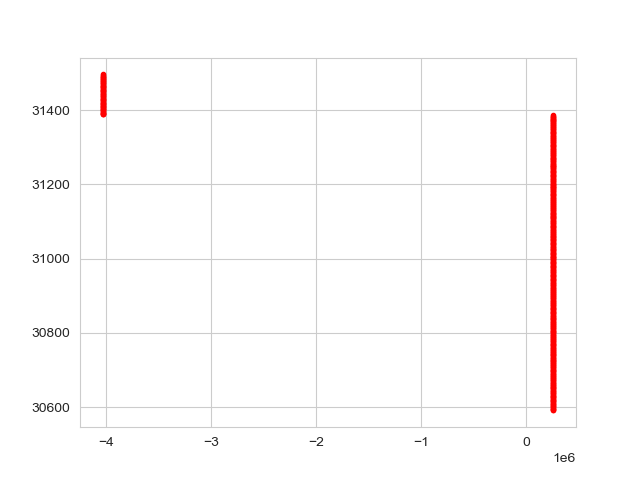

dataframe returned in 0.021941184997558594


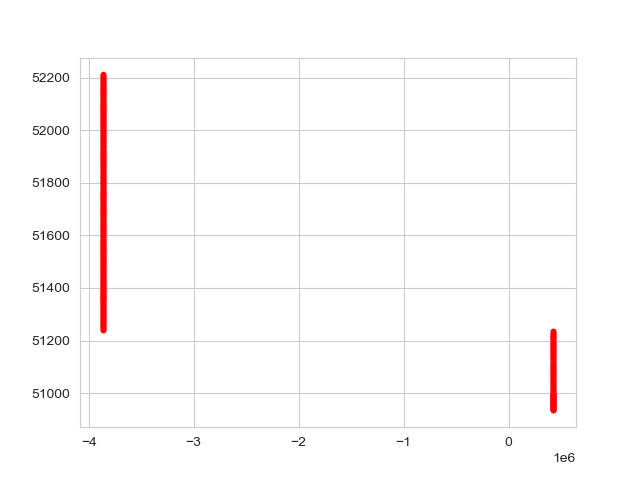

dataframe returned in 0.01498866081237793


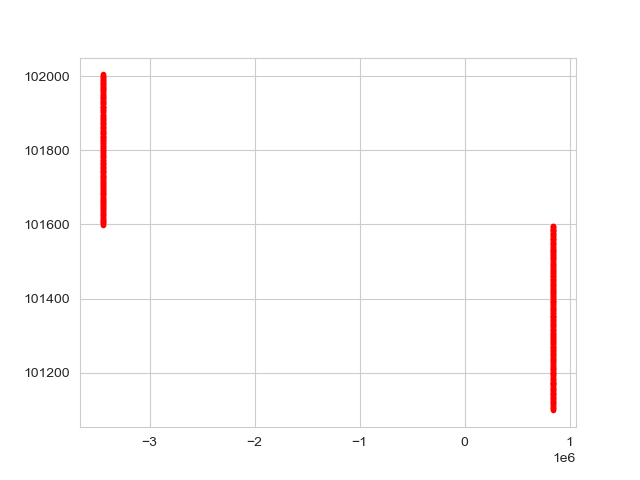

dataframe returned in 0.018053770065307617


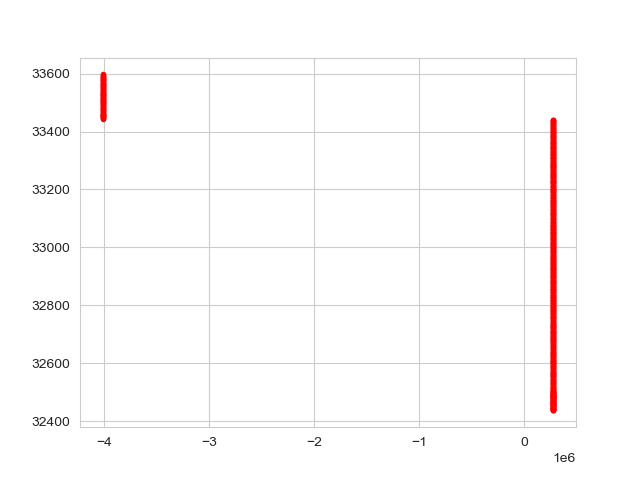

dataframe returned in 0.014931678771972656


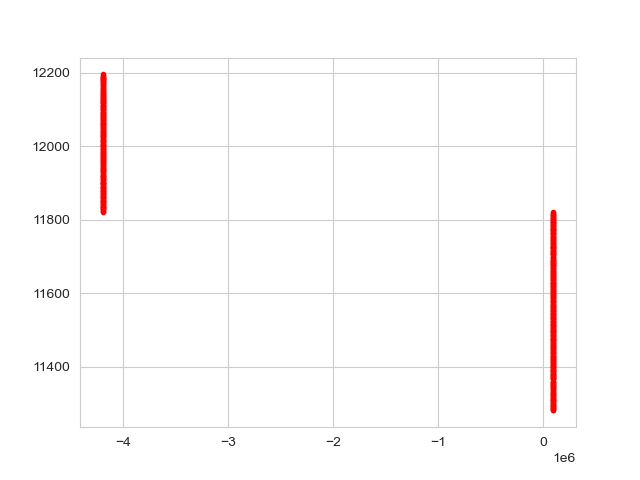

dataframe returned in 0.01795196533203125


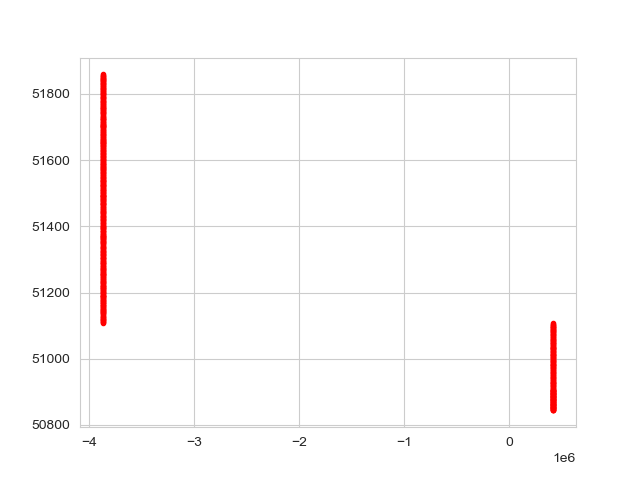

dataframe returned in 0.01795172691345215


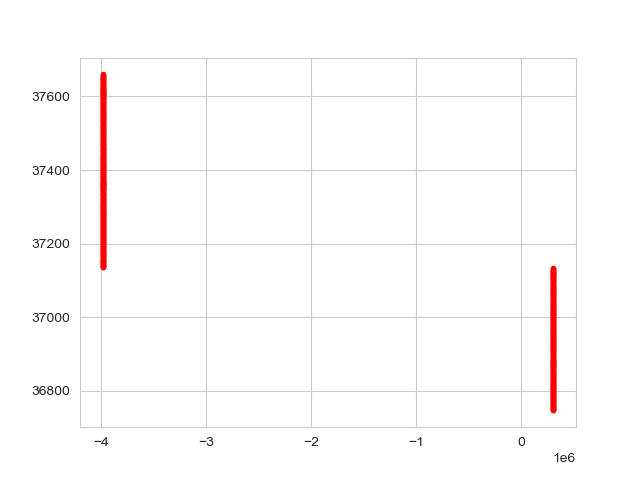

dataframe returned in 0.014991521835327148


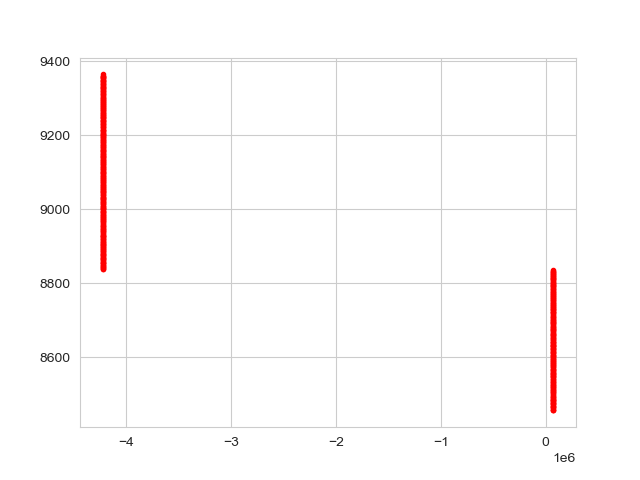